In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import spearmanr
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [2]:
sns.set()

## Import data and graph

,Unnamed: 0,Expanded Sequence,sgRNA Score,sgRNA Rank,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,0,GGCCGTAATGGCTTCCTCGTGAGTTGGTCC,0.325738,2708.0,0.410978,0,0,0,0,0,...,0,0,1,1,0,0,1,1,0,-41
1,1,AGAAGCTCGTGCGAGTGATAGACCAGGAGA,0.162559,1558.0,0.236425,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,-39
2,2,ATGGCACGGACGGTATATGGCAGGAGGTGG,0.035653,360.0,0.054586,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-41
3,3,TGGCTACTTCTGCGAGACACGGACAGGTCG,0.311042,2602.0,0.394889,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,-42
4,4,ACTTCGGCCCACGCTACTACAGTTCGGGCT,0.199951,1844.0,0.279835,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,-42


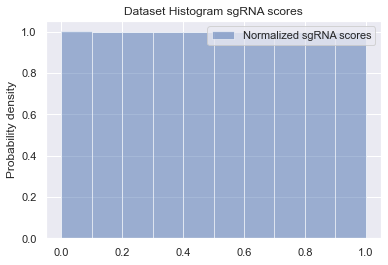

In [50]:
df = pd.read_csv("Doench_Fusi_V2_Featurized.csv")
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
# plt.hist(df["sgRNA Score"], alpha=0.5, density=True, label='Raw sgRNA scores')
plt.ylabel('Probability density')
plt.title("Dataset Histogram sgRNA scores")
plt.legend()
df.head()

In [51]:
features = df.columns.values
y_feat = "sgRNA Normalized"
features = np.delete(features, [0,1,2,3,4])
x_feat = features
x_feat

array(['A1', 'AA1', 'AG1', ..., 'TTC', 'TTT', 'Delta G'], dtype=object)

In [52]:
y = df.loc[:,y_feat].values
x = df[x_feat].values
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1
)

In [53]:
df[features].head()

,A1,AA1,AG1,AC1,AT1,A?,G1,GA1,GG1,GC1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,0,0,0,0,0,1,1,0,1,0,...,0,0,1,1,0,0,1,1,0,-41
1,1,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-39
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-41
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1,0,-42
4,1,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,-42


In [54]:
df.shape

(6588, 2496)

# Models

### 10-fold cross validation

In [55]:
def cross_validate_regression(model, df, x_feat_list, y_feat, n_splits=10):
    # computes the spearman correlation coefficient for each cross validated data set
    # takes in a model (estimator object), pandas dataframe, x features and the y-feature to predict, as well
    # as the number of splits (default is 10)
    #
    # returns a list of spearman correlation coefficients with length equal to the input n_splits
    
    # extract data into matrix
    x = df.loc[:, x_feat_list].values
    y_true = df.loc[:, y_feat].values
    
    kfold = KFold(n_splits=n_splits)
    
    # initialize an empty array same size as y_true
    y_pred = np.empty_like(y_true)
    
    # correlation list
    scc_list = np.array([])
    
    for train_idx, test_idx in kfold.split(x, y_true):
        # get training data
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # get testing data
        x_test = x[test_idx, :]
        y_true_test = y_true[test_idx]

        # train on training data
        model.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_pred[test_idx] = model.predict(x_test)
        
        scc_list = np.append(scc_list, spearmanr(y_pred[test_idx], y_true[test_idx]).correlation)
    
    return scc_list

### Lasso Regression / Feature Selection

In [56]:
# GridSearchCV for optimizing Lasso hyperparameters.
# DO NOT RUN! Will take >4.5 hours. Skip to next cell to run
# optimal lasso estimator.

# llr = Lasso();
# param_list = {"alpha": [0.005, 0.001, 0.0005, 0.0001, 0.00005], "max_iter": [1000000], "selection":["random"]}
# gridCV = GridSearchCV(estimator=llr, param_grid=param_list)
# cv_scores = cross_validate_regression(gridCV, df, features, y_feat)
# gridCV.best_estimator_

In [57]:
from sklearn.linear_model import Lasso
las = Lasso(alpha = .0005, max_iter = 1000000, random_state = 42)
las.fit(x, y)
las_ypred = las.predict(X_test)

lasso_df = pd.DataFrame()

lasso_df['Features'] = x_feat
lasso_df['Coefs'] = las.coef_

In [58]:
lasso_df.to_csv('Lasso_OnTarget_Feature_Coefficients.csv')
lasso_df.head()

,Features,Coefs
0,A1,-0.000000
1,AA1,0.001865
2,AG1,-0.000549
3,AC1,-0.001458
4,AT1,0.000000


### Gradient-Boosted Regression Tree

In [20]:
params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0218


In [21]:
# NOTE: this will take a while (~10 minutes) to run
gbrt_cvssc = cross_validate_regression(reg, df, x_feat, y_feat, 10)
gbrt_cvssc

array([0.92125984, 0.89126305, 0.91923984, 0.84706899, 0.8562706 ,
       0.8912516 , 0.90907686, 0.92220976, 0.89306805, 0.89480221])

##### Graphs of GBRT

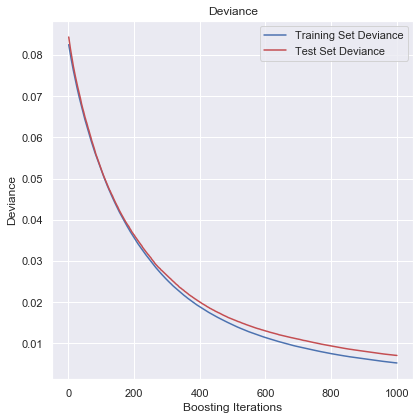

In [22]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

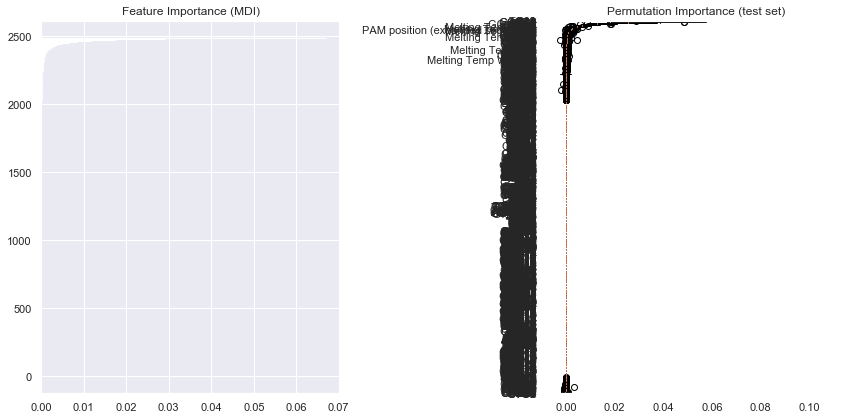

In [23]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
# plt.yticks(pos, x_feat)[sorted_idx]
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=x_feat[sorted_idx], # this might break it
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Linear Regression

In [33]:
ols = LinearRegression()
ols.fit(x, y)

mse = mean_squared_error(y_test, ols.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0196


In [34]:
lr_cvssc = cross_validate_regression(ols, df, x_feat, y_feat, 10)
lr_cvssc

array([0.87438655, 0.87381676, 0.87916779, 0.87715354, 0.88989913,
       0.87597281, 0.87722441, 0.87821474, 0.87754018, 0.88427971])

##### Graphs for LR

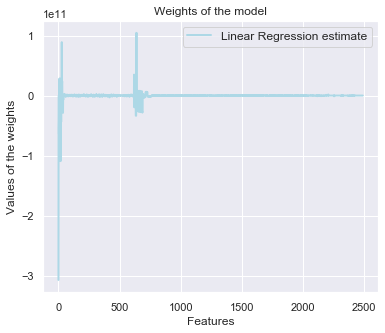

In [12]:
lw = 2
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(ols.coef_, color="lightblue", linewidth=lw, label="Linear Regression estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

<ipython-input-64-f648097c3fd8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["sgRNA Normalized"] = df["sgRNA Normalized"]
<ipython-input-64-f648097c3fd8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["sgRNA Normalized"] = df["sgRNA Normalized"]
<ipython-input-64-f648097c3fd8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

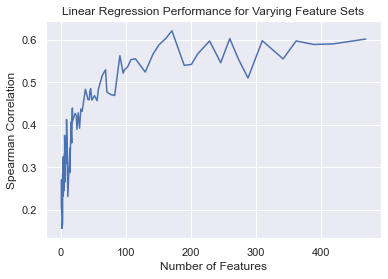

In [64]:
model = LinearRegression()
thresholds = np.linspace(0.1, 0.0001, num=100)
scc_list = np.array([])
feature_num_list = np.array([])
for t in thresholds:
    important_feats = lasso_df[abs(lasso_df['Coefs']) > t]
    x_feat_reduced = important_feats["Features"]
    df_reduced = df[x_feat_reduced]
    df_reduced["sgRNA Normalized"] = df["sgRNA Normalized"]
    y_red = df_reduced.loc[:,y_feat].values
    x_red = df_reduced[x_feat_reduced].values
    x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(
        x_red, y_red, test_size=0.1
    )
    model.fit(x_train_red, y_train_red)
    y_pred = model.predict(x_test_red)
    ssc = spearmanr(y_pred, y_test_red)
    # correlation list
    scc_list = np.append(scc_list, ssc[0])
    feature_num_list = np.append(feature_num_list, len(important_feats))
plt.plot(feature_num_list, scc_list)
plt.title('Linear Regression Performance for Varying Feature Sets')
plt.xlabel('Number of Features')
plt.ylabel('Spearman Correlation')
plt.savefig('OnTarget Linear Regression Feature Number Performance.png')
plt.show()

In [67]:
important_feats = lasso_df[abs(lasso_df['Coefs']) > 0.015]
important_feats

,Features,Coefs
8,GG1,-0.047410
9,GC1,0.020304
41,TG2,0.026526
54,C3,0.018599
76,CG4,0.046536
...,...,...
2448,GGC,0.029958
2460,CAC,0.015948
2463,CGG,0.028434
2486,TTA,-0.018778


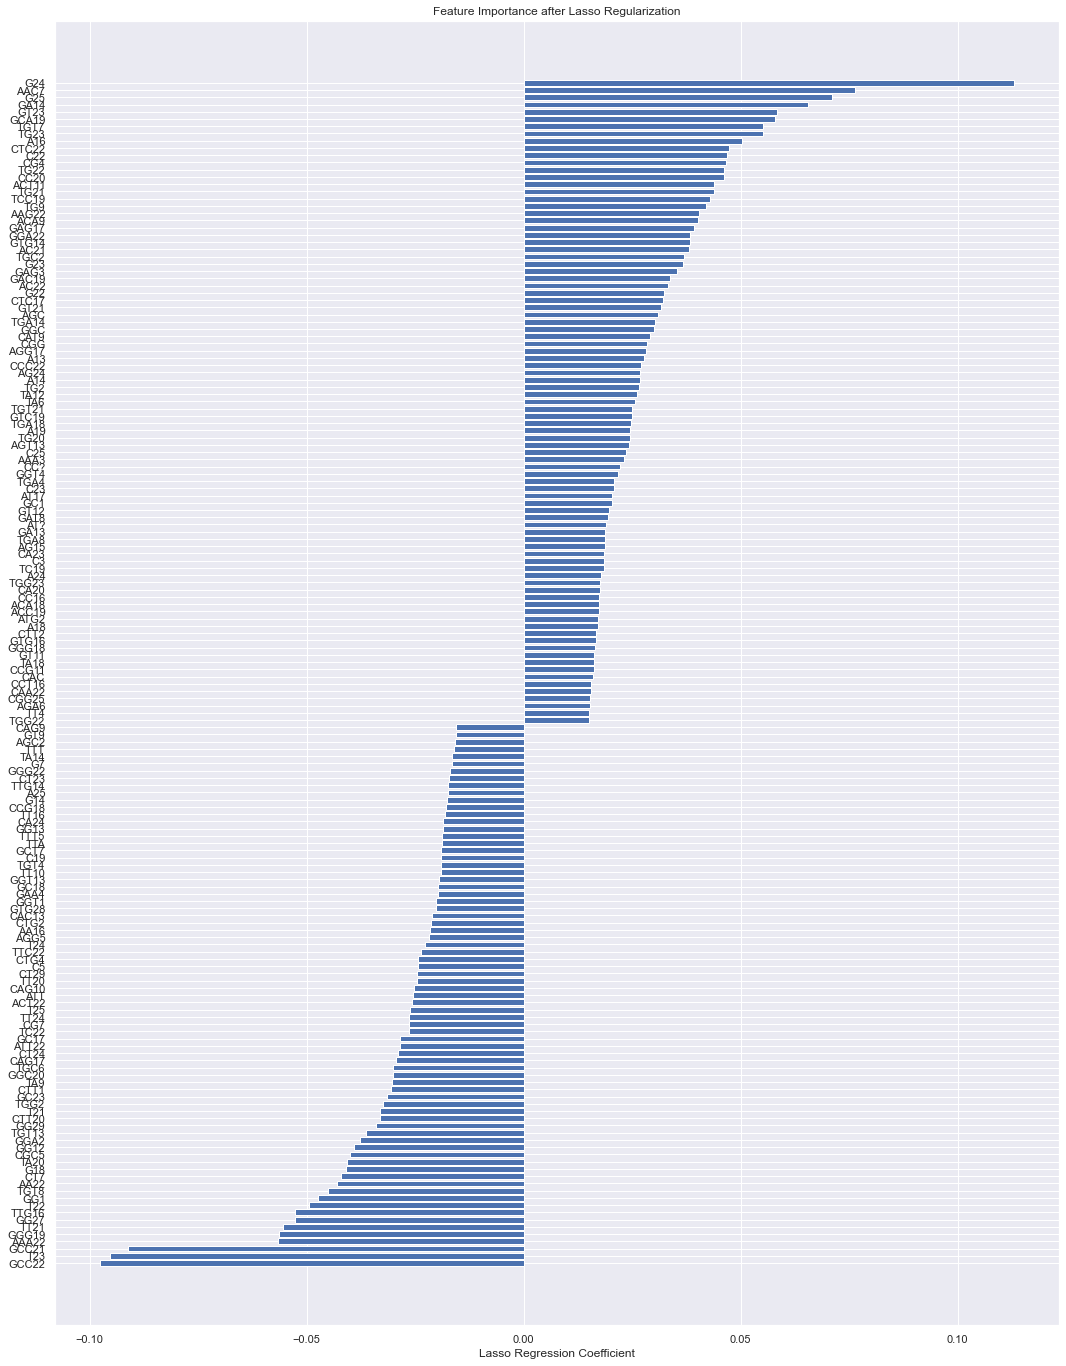

In [68]:
feature_sorted = important_feats.sort_values(by='Coefs')
fig = plt.figure(figsize=(18, 24))
plt.barh(feature_sorted["Features"], feature_sorted["Coefs"])
plt.title("Feature Importance after Lasso Regularization")
plt.xlabel("Lasso Regression Coefficient")
plt.savefig("OnTarget Feature Importance after Lasso.png")
plt.show()

### Bayesian Ridge Regression

In [13]:
# Fit the Bayesian Ridge Regression and an OLS for comparison
clf = BayesianRidge(compute_score=True)
clf.fit(x, y)

mse = mean_squared_error(y_test, clf.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0507


In [14]:
brr_cvssc = cross_validate_regression(clf, df, x_feat, y_feat, 10)
brr_cvssc

array([0.65106144, 0.60862624, 0.39911011, 0.39986756, 0.51868801,
       0.52543888, 0.40456509, 0.42186708, 0.46172486, 0.45718124])

##### Graphs

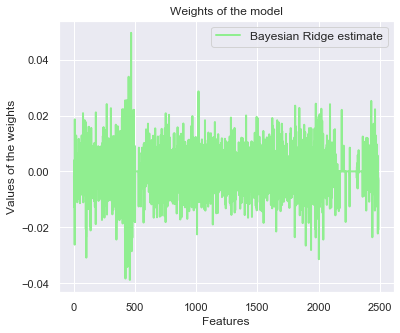

In [15]:
lw = 2
plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
# plt.plot(ols.coef_, color="lightblue", linestyle="--", label="Linear Regression estimate")
plt.plot(clf.coef_, color="lightgreen", linewidth=lw, label="Bayesian Ridge estimate")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc="best", prop=dict(size=12))

### Neural Network Regressor

In [29]:
# GridSearchCV for optimizing Lasso hyperparameters.
# DO NOT RUN! Will take >10.5 hours. Skip to next cell to run
# optimal neural network regressor.

# mlp = MLPRegressor();
# param_list = {"hidden_layer_sizes": [(20,),(50,),(100,),(200,),(50,50),(100,100),(200,200)], "activation": ["tanh", "relu"], "solver": ["adam"], "alpha": [0.0005]}
# gridCVNN = GridSearchCV(estimator=mlp, param_grid=param_list)
# cv_scores = cross_validate_regression(gridCVNN, df, features, y_feat)
# gridCVNN.best_estimator_

C:\Users\ianha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [16]:
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        hidden_layer_sizes=(100, 100),
        learning_rate_init=0.0005,
        early_stopping=True,
        random_state=0,
        activation='tanh',
    ),
)
est.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {est.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 7.501s
Test R2 score: 0.18


In [17]:
nn_cvssc = cross_validate_regression(est, df, x_feat, y_feat, 10)

In [15]:
nn_cvssc

array([0.64362732, 0.5917438 , 0.37326112, 0.40282869, 0.49719501,
       0.52608502, 0.37514519, 0.40403103, 0.40499746, 0.46094527])

## Model Performance

<BarContainer object of 3 artists>

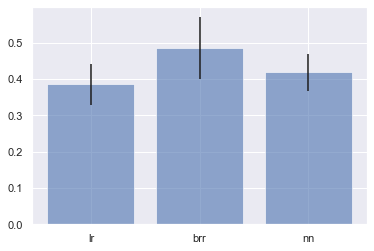

In [18]:
models = ['lr', 'brr', 'nn']
values = [lr_cvssc.mean(), brr_cvssc.mean(), nn_cvssc.mean()]
# error = [sem(gbrt_cvssc), sem(lr_cvssc), sem(brr_cvssc), sem(nn_cvssc)]
error = [lr_cvssc.std(), brr_cvssc.std(), nn_cvssc.std()]

plt.bar(models, values, yerr=error, alpha=0.6)